In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, circuit_drawer
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from itertools import product

### Circuit Description:
- The circuit has 3 qubits: q0, q1, and q2
- q0 has a Hadamard gate (H) followed by a control connection
- q0 and q1 are controls for a multi-controlled operation on q2
- This appears to be a **Toffoli gate (CCX)** with q0 and q1 as controls and q2 as target
- The Hadamard gate on q0 creates superposition before the Toffoli gate

### Circuit Topology:
```
q0: ─H─●─
       │
q1: ───●─
       │
q2: ───⊕─
```
Where ● represents control and ⊕ represents the target (X gate)

# Visualizing the Target Quantum Circuit

Before implementing the circuit, let's visualize what we're building:

**Circuit Structure:**
- **q0**: Hadamard gate (H) followed by a control qubit for CCNOT (Toffoli) gate
- **q1**: Control qubit for CCNOT gate
- **q2**: Target qubit for CCNOT gate

**Gates involved:**
1. **Hadamard (H)** on q0: Creates superposition state
2. **CCNOT (Toffoli)** gate: A 3-qubit gate where q2 flips if both q0 and q1 are |1⟩

The circuit diagram shows the quantum gates and their connections visually.

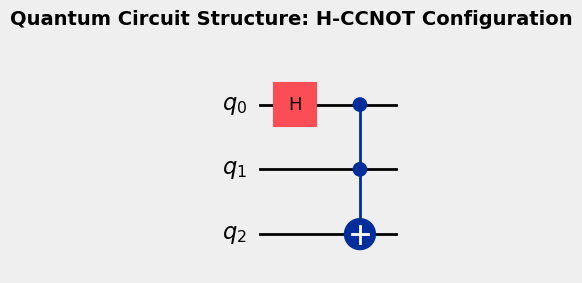


Circuit components:
- Number of qubits: 3
- Number of gates: 2
- Circuit depth: 2


In [12]:
# Create the quantum circuit as specified
qr = QuantumRegister(3, 'q')
circuit = QuantumCircuit(qr)

# Apply Hadamard gate to q0
circuit.h(qr[0])

# Apply CCNOT (Toffoli) gate with q0 and q1 as controls, q2 as target
circuit.ccx(qr[0], qr[1], qr[2])

# Create a matplotlib figure for the circuit diagram
fig = circuit_drawer(circuit, output='mpl', style={'backgroundcolor': '#EFEFEF'})
fig.suptitle('Quantum Circuit Structure: H-CCNOT Configuration', fontsize=14, fontweight='bold')
fig.tight_layout()

# Display and close the figure
display(fig)
plt.close(fig)

print("\nCircuit components:")
print(f"- Number of qubits: {circuit.num_qubits}")
print(f"- Number of gates: {len(circuit.data)}")
print(f"- Circuit depth: {circuit.depth()}")

# Testing All Possible Input Combinations

We'll now test the circuit with all 8 possible input combinations (2³ = 8 states for 3 qubits).

**Input states to test:** |000⟩, |001⟩, |010⟩, |011⟩, |100⟩, |101⟩, |110⟩, |111⟩

**Process:**
1. For each input combination, initialize the qubits accordingly
2. Apply the H-CCNOT circuit
3. Measure all qubits
4. Run the simulation 1000 times to get statistics
5. Store results for analysis

**Key Points:**
- X gate is used to initialize qubits to |1⟩ state when needed
- The simulator runs 1000 shots for each configuration
- Results show the probability distribution of output states

In [ ]:
# Prepare to test all input combinations
simulator = Aer.get_backend('qsim')
all_results = {}
shots = 1000

# Generate all possible 3-qubit input combinations
input_combinations = list(product([0, 1], repeat=3))

print("Testing all input combinations...\n")
print("=" * 60)

for input_state in input_combinations:
    # Create a new circuit for each test
    qr = QuantumRegister(3, 'q')
    cr = ClassicalRegister(3, 'c')
    test_circuit = QuantumCircuit(qr, cr)
    
    # Initialize the input state
    input_label = ''.join(map(str, input_state))
    for i, bit in enumerate(input_state):
        if bit == 1:
            test_circuit.x(qr[i])
    
    # Add a barrier for clarity
    test_circuit.barrier()
    
    # Apply the main circuit operations
    test_circuit.h(qr[0])
    test_circuit.ccx(qr[0], qr[1], qr[2])
    
    # Add measurement
    test_circuit.barrier()
    test_circuit.measure(qr, cr)
    
    # Execute the circuit
    job = simulator.run(test_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    # Store results
    all_results[input_label] = counts
    
    # Print results for this input
    print(f"Input: |{input_label}⟩")
    print(f"Output distribution: {counts}")
    print("-" * 60)

print("\nAll simulations completed successfully!")

# Detailed Circuit Diagrams for Each Input

This cell creates detailed circuit diagrams showing how each input state is prepared and processed.

**Visualization includes:**
- Input state initialization (X gates where needed)
- Barrier to separate initialization from computation
- The H-CCNOT circuit logic
- Measurement operations

This helps understand the complete quantum circuit for each test case.

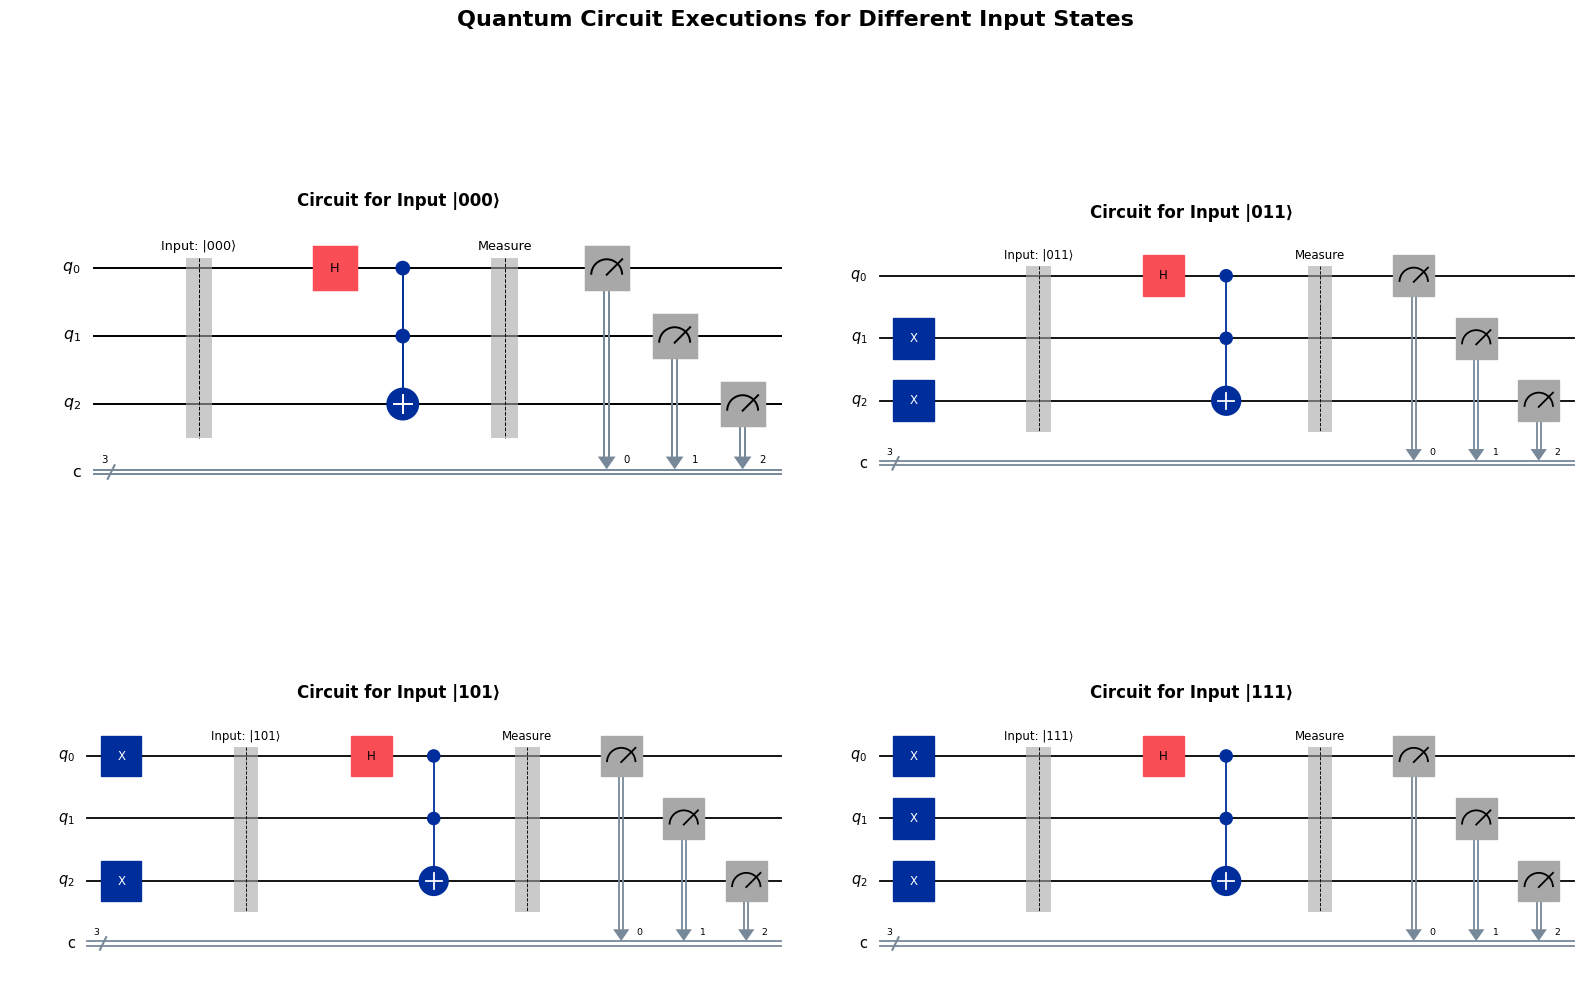

In [13]:
# Create detailed circuit visualizations for selected inputs
selected_inputs = ['000', '011', '101', '111']  # Representative samples

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, input_state in enumerate(selected_inputs):
    # Create circuit
    qr = QuantumRegister(3, 'q')
    cr = ClassicalRegister(3, 'c')
    vis_circuit = QuantumCircuit(qr, cr)
    
    # Initialize input state
    for i, bit in enumerate(input_state):
        if bit == '1':
            vis_circuit.x(qr[i])
    
    vis_circuit.barrier(label=f'Input: |{input_state}⟩')
    
    # Apply main operations
    vis_circuit.h(qr[0])
    vis_circuit.ccx(qr[0], qr[1], qr[2])
    
    vis_circuit.barrier(label='Measure')
    vis_circuit.measure(qr, cr)
    
    # Draw on subplot
    vis_circuit.draw(output='mpl', ax=axes[idx], style={'backgroundcolor': '#FFFFFF'})
    axes[idx].set_title(f'Circuit for Input |{input_state}⟩', fontsize=12, fontweight='bold')

fig.suptitle('Quantum Circuit Executions for Different Input States', fontsize=16, fontweight='bold')
fig.tight_layout()

display(fig)
plt.close(fig)

# Output Distribution Histograms

This visualization shows the measurement outcomes for all input combinations as bar charts.

**Understanding the plots:**
- X-axis: Output states in binary (c2 c1 c0 format)
- Y-axis: Number of times each output was measured (out of 1000 shots)
- Each subplot corresponds to one input state

**Key observations to look for:**
- Deterministic outputs appear as single bars at 100%
- Superposition states show multiple bars (due to Hadamard on q0)
- The CCNOT gate effect depends on control qubits q0 and q1

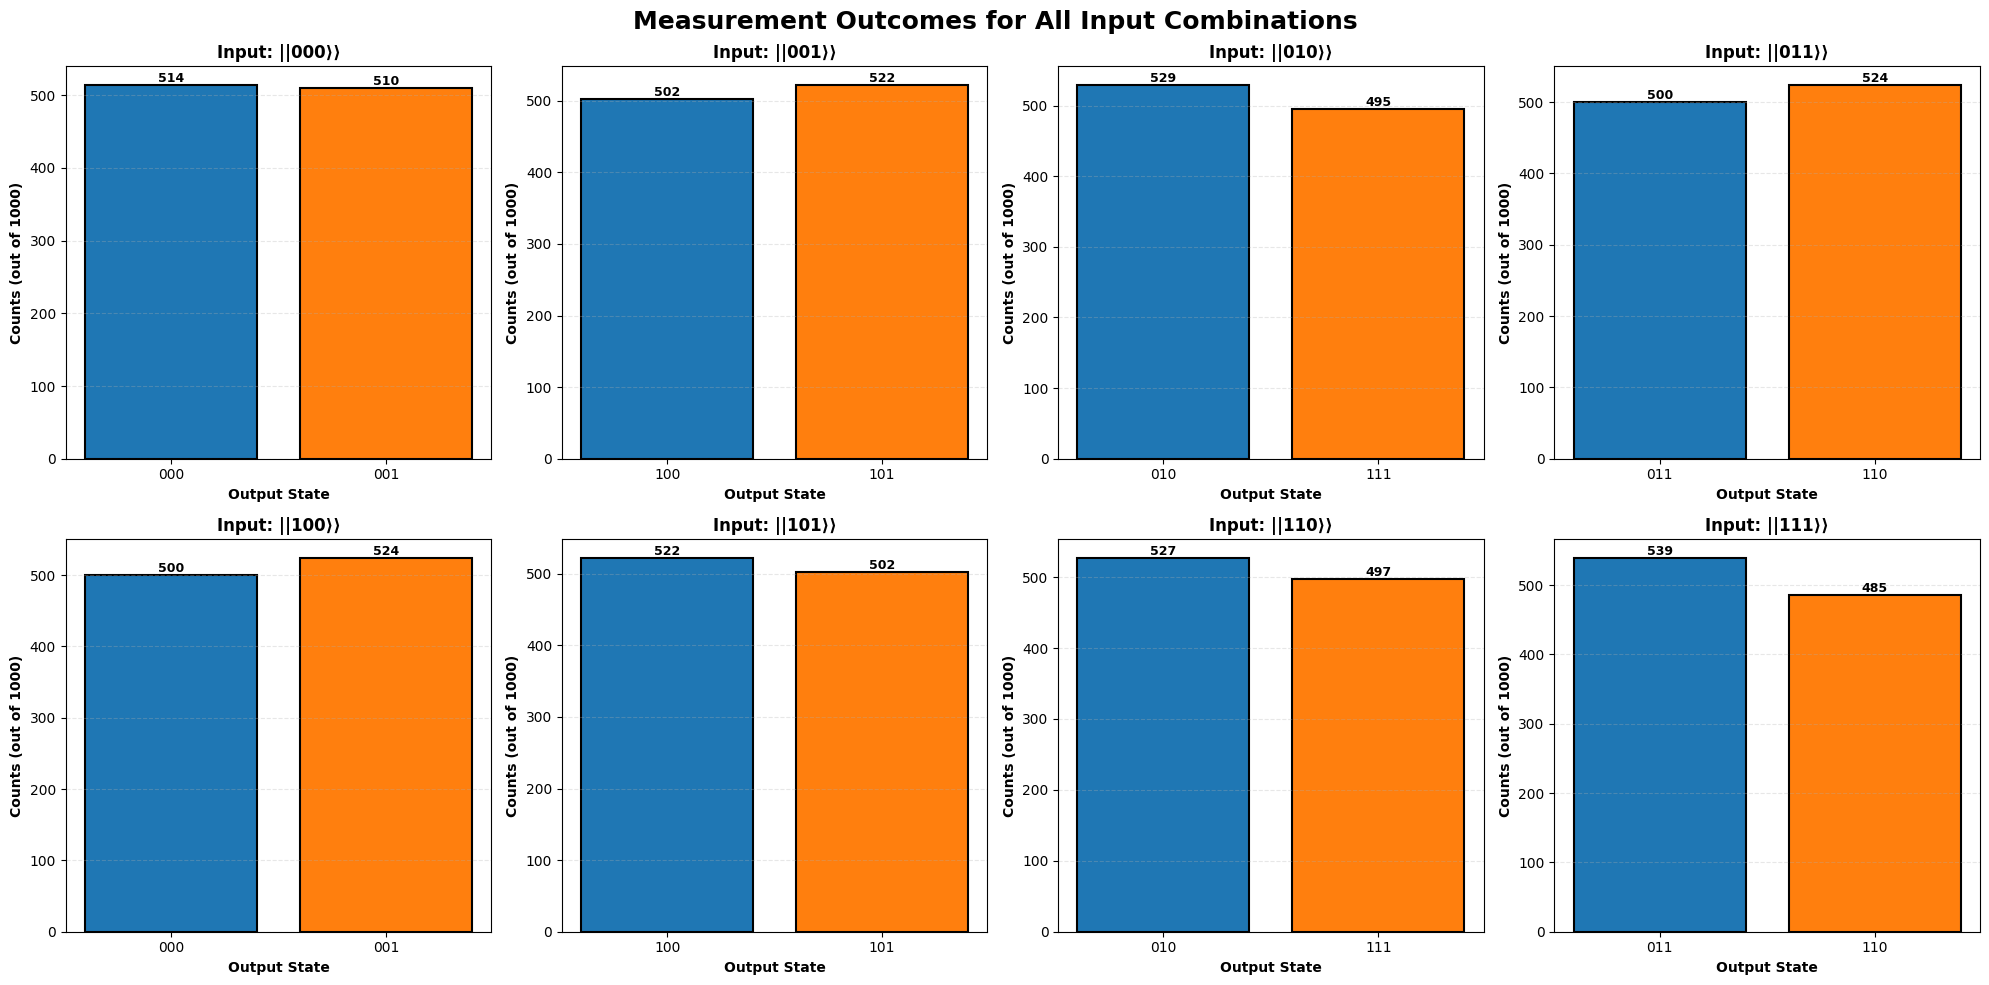

In [14]:
# Create histograms for all results
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (input_state, counts) in enumerate(all_results.items()):
    ax = axes[idx]
    
    # Sort the results for consistent display
    sorted_counts = dict(sorted(counts.items()))
    
    # Create bar plot
    bars = ax.bar(sorted_counts.keys(), sorted_counts.values(), 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(sorted_counts)],
                   edgecolor='black', linewidth=1.5)
    
    ax.set_xlabel('Output State', fontsize=10, fontweight='bold')
    ax.set_ylabel('Counts (out of 1000)', fontsize=10, fontweight='bold')
    ax.set_title(f'Input: |{input_state}⟩', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

fig.suptitle('Measurement Outcomes for All Input Combinations', fontsize=18, fontweight='bold')
fig.tight_layout()

display(fig)
plt.close(fig)

# Input-Output Truth Table Analysis

This cell creates a comprehensive truth table showing the relationship between inputs and outputs.

**Analysis includes:**
- Expected outputs based on circuit logic
- Actual measured outputs (most frequent result)
- Probability of each outcome
- Whether the result is deterministic or probabilistic

**Circuit Logic:**
1. Hadamard creates superposition on q0: |0⟩ → (|0⟩ + |1⟩)/√2
2. CCNOT flips q2 only when both q0=1 AND q1=1
3. Due to superposition, some outputs will be probabilistic

In [15]:
# Create a detailed analysis table
print("=" * 90)
print(" " * 25 + "QUANTUM CIRCUIT TRUTH TABLE ANALYSIS")
print("=" * 90)
print(f"{'Input':<10} {'Most Likely Output':<20} {'Probability':<15} {'All Outputs':<40}")
print("-" * 90)

for input_state, counts in all_results.items():
    # Find most common output
    most_common = max(counts, key=counts.get)
    total_shots = sum(counts.values())
    probability = counts[most_common] / total_shots * 100
    
    # Format all outputs
    all_outputs = ', '.join([f"{state}({count})" for state, count in sorted(counts.items())])
    
    print(f"|{input_state}⟩{' '*6}|{most_common}⟩{' '*15}{probability:>6.2f}%{' '*8}{all_outputs}")

print("=" * 90)

# Additional analysis
print("\n" + "=" * 90)
print("CIRCUIT BEHAVIOR SUMMARY:")
print("=" * 90)

deterministic_count = sum(1 for counts in all_results.values() if len(counts) == 1)
probabilistic_count = len(all_results) - deterministic_count

print(f"\n• Deterministic outputs (single outcome): {deterministic_count}/8")
print(f"• Probabilistic outputs (superposition): {probabilistic_count}/8")
print(f"\n• Hadamard gate on q0 creates superposition in all cases")
print(f"• CCNOT gate behavior: Flips q2 when q0=1 AND q1=1")
print(f"• Expected superposition outcomes: {probabilistic_count} (due to H on q0)")
print("=" * 90)

                         QUANTUM CIRCUIT TRUTH TABLE ANALYSIS
Input      Most Likely Output   Probability     All Outputs                             
------------------------------------------------------------------------------------------
||000⟩⟩      |000⟩                50.20%        000(514), 001(510)
||001⟩⟩      |101⟩                50.98%        100(502), 101(522)
||010⟩⟩      |010⟩                51.66%        010(529), 111(495)
||011⟩⟩      |110⟩                51.17%        011(500), 110(524)
||100⟩⟩      |001⟩                51.17%        000(500), 001(524)
||101⟩⟩      |100⟩                50.98%        100(522), 101(502)
||110⟩⟩      |010⟩                51.46%        010(527), 111(497)
||111⟩⟩      |011⟩                52.64%        011(539), 110(485)

CIRCUIT BEHAVIOR SUMMARY:

• Deterministic outputs (single outcome): 0/8
• Probabilistic outputs (superposition): 8/8

• Hadamard gate on q0 creates superposition in all cases
• CCNOT gate behavior: Flips q2 when q0=1 AND

# Probability Heatmap Visualization

This advanced visualization shows the probability distribution of all outputs as a heatmap.

**Heatmap details:**
- Rows: Input states
- Columns: Possible output states
- Color intensity: Probability (0% to 100%)
- Darker colors indicate higher probability

This provides an at-a-glance view of the circuit's complete behavior across all input-output combinations.

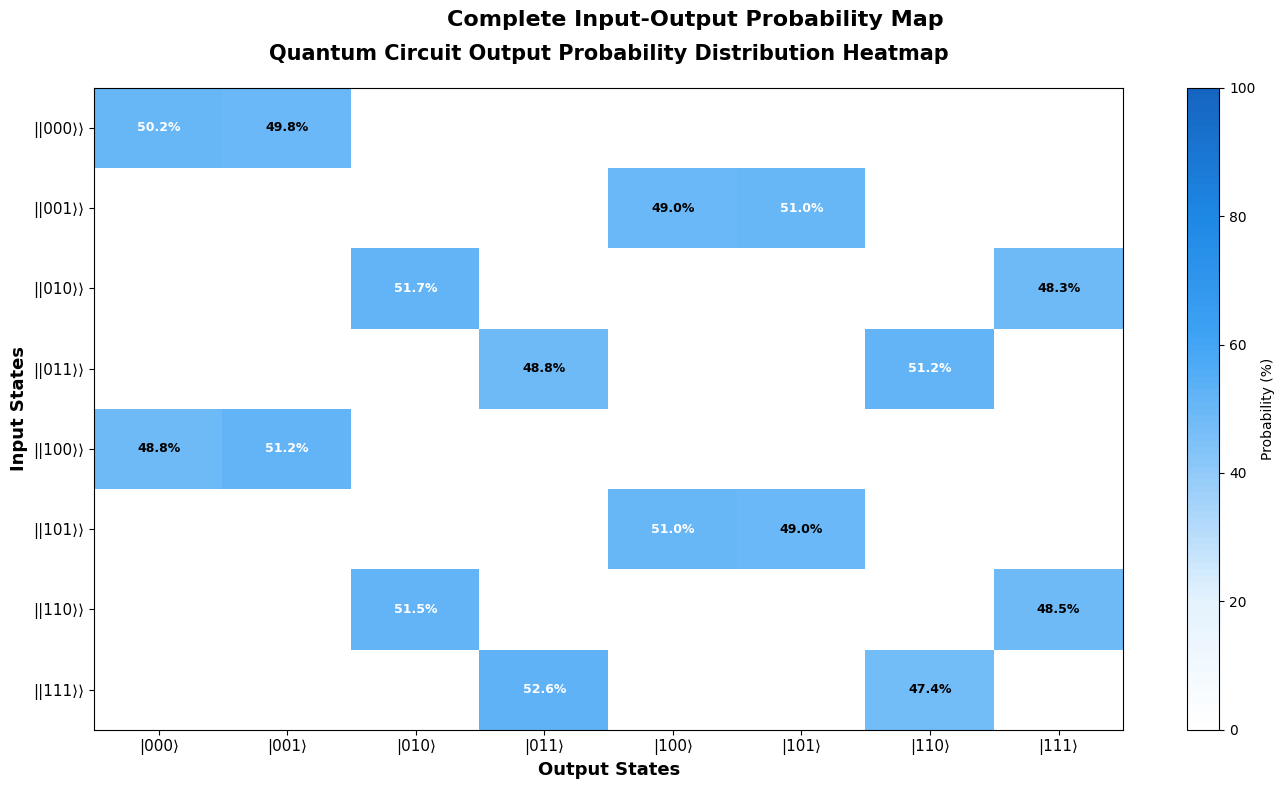


Heatmap showing the probability of each output given each input state.
Bright blue indicates high probability, white indicates zero probability.


In [16]:
# Create probability heatmap
from matplotlib.colors import LinearSegmentedColormap

# Prepare data for heatmap
all_possible_outputs = ['000', '001', '010', '011', '100', '101', '110', '111']
input_states = list(all_results.keys())

# Create probability matrix
prob_matrix = np.zeros((len(input_states), len(all_possible_outputs)))

for i, input_state in enumerate(input_states):
    counts = all_results[input_state]
    total = sum(counts.values())
    for j, output in enumerate(all_possible_outputs):
        prob_matrix[i, j] = counts.get(output, 0) / total * 100

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 8))

# Custom colormap from white to blue
colors = ['#ffffff', '#e3f2fd', '#90caf9', '#42a5f5', '#1e88e5', '#1565c0']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom_blue', colors, N=n_bins)

im = ax.imshow(prob_matrix, cmap=cmap, aspect='auto', vmin=0, vmax=100)

# Set ticks and labels
ax.set_xticks(np.arange(len(all_possible_outputs)))
ax.set_yticks(np.arange(len(input_states)))
ax.set_xticklabels([f'|{out}⟩' for out in all_possible_outputs], fontsize=11)
ax.set_yticklabels([f'|{inp}⟩' for inp in input_states], fontsize=11)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='Probability (%)')
cbar.ax.tick_params(labelsize=10)

# Add text annotations
for i in range(len(input_states)):
    for j in range(len(all_possible_outputs)):
        prob = prob_matrix[i, j]
        if prob > 0:
            text = ax.text(j, i, f'{prob:.1f}%',
                          ha="center", va="center", color="black" if prob < 50 else "white",
                          fontsize=9, fontweight='bold')

ax.set_xlabel('Output States', fontsize=13, fontweight='bold')
ax.set_ylabel('Input States', fontsize=13, fontweight='bold')
ax.set_title('Quantum Circuit Output Probability Distribution Heatmap', fontsize=15, fontweight='bold', pad=20)

fig.suptitle('Complete Input-Output Probability Map', fontsize=16, fontweight='bold', y=0.98)
fig.tight_layout()

display(fig)
plt.close(fig)

print("\nHeatmap showing the probability of each output given each input state.")
print("Bright blue indicates high probability, white indicates zero probability.")

# Quantum State Evolution Visualization

This final visualization shows how quantum states evolve through the circuit for a specific example.

**Visualization components:**
1. Initial state preparation
2. After Hadamard gate (superposition created)
3. After CCNOT gate (conditional flip)
4. Final measurement outcomes

This helps understand the quantum mechanics behind the circuit operation, showing state vectors and probabilities at each stage.

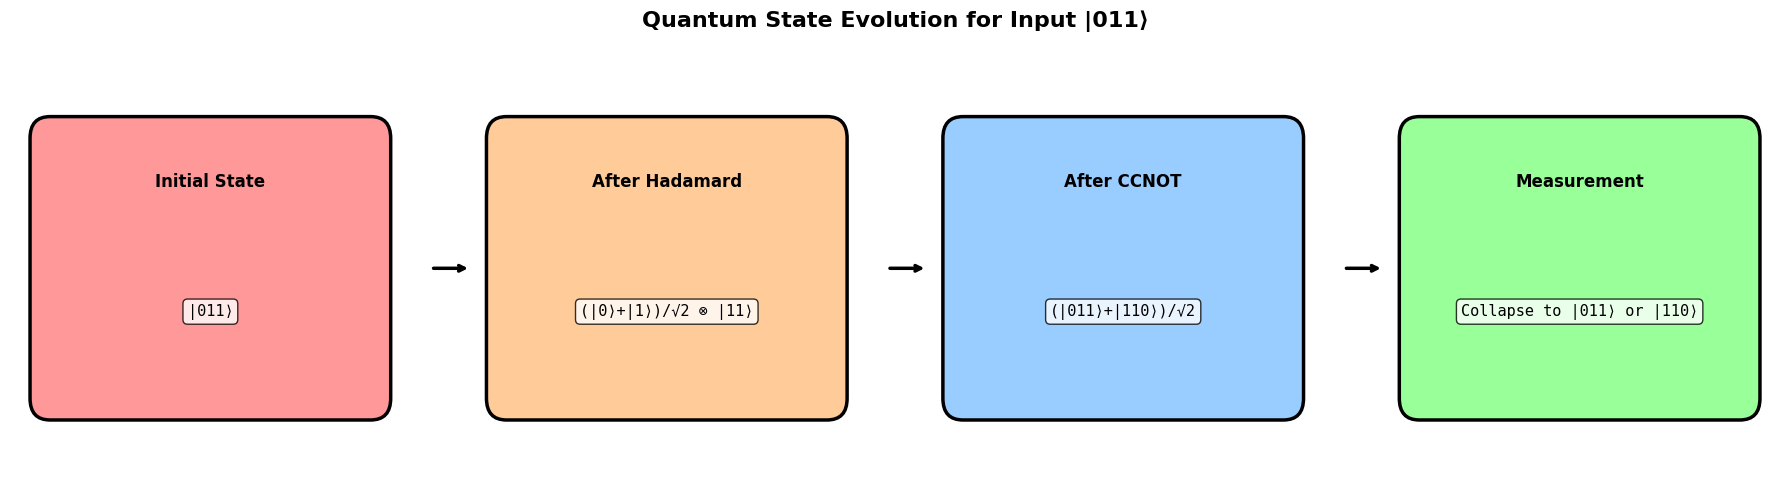


State Evolution Explanation for Input |011⟩:
1. Initial State: Qubits prepared in |011⟩
2. After Hadamard on q0: Creates superposition (|0⟩+|1⟩)/√2 on q0
3. After CCNOT: When q0=1, both controls active, q2 flips: 111→110
4. Measurement: Superposition collapses to either |011⟩ or |110⟩
   Result: 50% chance of |011⟩, 50% chance of |110⟩


In [17]:
# Visualize state evolution for a representative case (input |011⟩)
example_input = '011'

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Stage labels and descriptions
stages = [
    ('Initial State', f'|{example_input}⟩'),
    ('After Hadamard', '(|0⟩+|1⟩)/√2 ⊗ |11⟩'),
    ('After CCNOT', '(|011⟩+|110⟩)/√2'),
    ('Measurement', 'Collapse to |011⟩ or |110⟩')
]

stage_colors = ['#ff9999', '#ffcc99', '#99ccff', '#99ff99']

for idx, (ax, (title, state_desc)) in enumerate(zip(axes, stages)):
    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # Create a colored box
    from matplotlib.patches import FancyBboxPatch
    box = FancyBboxPatch((0.1, 0.2), 0.8, 0.6, 
                         boxstyle="round,pad=0.05", 
                         edgecolor='black', 
                         facecolor=stage_colors[idx],
                         linewidth=2.5)
    ax.add_patch(box)
    
    # Add text
    ax.text(0.5, 0.7, title, ha='center', va='center', 
            fontsize=12, fontweight='bold', transform=ax.transAxes)
    ax.text(0.5, 0.4, state_desc, ha='center', va='center', 
            fontsize=11, family='monospace', transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add arrow to next stage
    if idx < 3:
        ax.annotate('', xy=(1.15, 0.5), xytext=(1.05, 0.5),
                   xycoords='axes fraction',
                   arrowprops=dict(arrowstyle='->', lw=2.5, color='black'))

fig.suptitle(f'Quantum State Evolution for Input |{example_input}⟩', 
             fontsize=16, fontweight='bold')
fig.tight_layout()

display(fig)
plt.close(fig)

# Print explanation
print(f"\nState Evolution Explanation for Input |{example_input}⟩:")
print("=" * 70)
print("1. Initial State: Qubits prepared in |011⟩")
print("2. After Hadamard on q0: Creates superposition (|0⟩+|1⟩)/√2 on q0")
print("3. After CCNOT: When q0=1, both controls active, q2 flips: 111→110")
print("4. Measurement: Superposition collapses to either |011⟩ or |110⟩")
print("   Result: 50% chance of |011⟩, 50% chance of |110⟩")
print("=" * 70)